# How to make people live longer if you are a government representative



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
import warnings
import seaborn as sns
import plotly.figure_factory as ff

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import RFECV


import statsmodels.api as sm
from patsy import dmatrices
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

%load_ext autoreload

%autoreload 2
% matplotlib inline

In [2]:
xls = pd.ExcelFile('./Dataset/2019 County Health Rankings Data - v2.xls')
df = pd.read_csv('./Dataset/analytic_data2019.csv')
#df2 = pd.read_excel(xls, 'Outcomes & Factors SubRankings')
df3 = pd.read_excel(xls, 'Ranked Measure Data',skiprows=1)
life_exp = pd.read_excel(xls, 'Additional Measure Data',skiprows=1)

In [3]:
df3 = utils.drop_cols(df3,300)

cols_drop = [col for col in df3.columns if '95% CI' in col or "Quartile" in col or "Percentile" in col]
cols_drop.extend([col for col in df3.columns if 'numerator' in col or 'denominator' in col])
df3.drop(cols_drop,axis=1,inplace=True)
display(df3.head())
df3.shape

,FIPS,State,County,Years of Potential Life Lost Rate,% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,% LBW,% Smokers,% Obese,...,Injury Death Rate,Average Daily PM2.5,Presence of violation,% Severe Housing Problems,Severe Housing Cost Burden,Overcrowding,Inadequate Facilities,% Drive Alone,# Workers who Drive Alone,% Long Commute - Drives Alone
0,1001,Alabama,Autauga,8824.057123,18.411124,4.200578,4.306739,8.475719,19.124658,37.5,...,74.031808,11.7,No,14.954646,13.205223,2.451581,0.637411,85.965057,20911,38.3
1,1003,Alabama,Baldwin,7224.632160,18.060458,4.098748,4.249649,8.338683,16.795485,31.0,...,69.374289,10.3,Yes,13.831725,12.569278,1.072802,0.607246,84.719423,74415,40.5
2,1005,Alabama,Barbour,9586.165037,25.773416,5.067438,4.634994,10.952624,21.540878,44.3,...,72.900134,11.5,No,15.455531,13.674263,2.006508,0.813449,83.404353,7242,33.8
3,1007,Alabama,Bibb,11783.543675,19.996912,4.363377,4.315710,11.105003,19.916404,37.8,...,100.077937,11.2,No,10.960854,10.808081,0.199288,0.284698,86.365902,6930,48.6
4,1009,Alabama,Blount,10908.101822,21.095323,4.512753,4.701599,7.926829,19.652158,34.4,...,105.197227,11.7,No,10.401153,7.945879,1.724718,0.912803,86.792275,18426,59.7


(3142, 62)

# Plotting Interactive Plots of Life Expectency

In [4]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode , iplot ,plot
init_notebook_mode(connected = True)
import cufflinks as cf
cf.go_offline()


In [6]:
life_exp.iplot(kind = "bar" , x = "State" , y = "Life Expectancy" , xTitle = "County Name" ,
         yTitle = "Life Expectency" , title = "Life Expectancy Of States")

In [18]:
cols_drop = [col for col in life_exp.columns if '95% CI' in col]
life_exp.drop(cols_drop,axis=1,inplace=True)

In [19]:
merged_df = life_exp.set_index('FIPS').join(df3.set_index('FIPS'), how="inner",lsuffix='_left', rsuffix='_right')

cols_drop = [col for col in merged_df.columns if '_right' in col or 'Hispanic' in col or 'White' in col or 
             '# ' in col or 'Black' in col]
merged_df.drop(cols_drop,axis=1,inplace=True)
merged_df.reset_index(inplace=True)



In [20]:
merged_df.shape

(3142, 82)

In [21]:
final_df = utils.drop_cols(merged_df,500)

final_df.head()

,FIPS,State_left,County_left,Life Expectancy,Age-Adjusted Mortality,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,% Food Insecure,% Limited Access,...,Violent Crime Rate,Injury Death Rate,Average Daily PM2.5,Presence of violation,% Severe Housing Problems,Severe Housing Cost Burden,Overcrowding,Inadequate Facilities,% Drive Alone,% Long Commute - Drives Alone
0,1001,Alabama,Autauga,76.330589,438.7,12.824434,12.638357,14.2,13.4,11.991125,...,272.282220,74.031808,11.7,No,14.954646,13.205223,2.451581,0.637411,85.965057,38.3
1,1003,Alabama,Baldwin,78.599498,348.4,12.622002,12.822558,11.3,12.3,5.424427,...,203.660396,69.374289,10.3,Yes,13.831725,12.569278,1.072802,0.607246,84.719423,40.5
2,1005,Alabama,Barbour,75.779457,469.8,16.216160,14.632311,18.0,23.2,10.739667,...,414.277861,72.900134,11.5,No,15.455531,13.674263,2.006508,0.813449,83.404353,33.8
3,1007,Alabama,Bibb,73.928271,563.7,13.162968,12.854036,14.9,15.8,2.601627,...,89.349126,100.077937,11.2,No,10.960854,10.808081,0.199288,0.284698,86.365902,48.6
4,1009,Alabama,Blount,74.597767,501.8,13.720057,13.827943,14.3,11.0,2.880150,...,482.690611,105.197227,11.7,No,10.401153,7.945879,1.724718,0.912803,86.792275,59.7


In [22]:
nul_cols = []
for col in final_df.columns:
    if any(final_df[col].isna()):
        
        nul_cols.append(col)
for col in nul_cols:
    try:
        final_df.fillna(final_df[col].median(), inplace=True)
    except:
        continue

In [23]:
merged_corr = final_df.corr()
highly_cor = []
for col,val in zip(merged_corr.index,merged_corr['Life Expectancy']):
    if abs(val) > 0.5:
        highly_cor.append(col)
# Remove columns where it is closely related to life expectancy        
highly_cor.remove('Age-Adjusted Mortality')
#highly_cor.remove('Life expectancy raw value')
highly_cor

['Life Expectancy',
 '% Frequent Physical Distress',
 '% Frequent Mental Distress',
 '% Diabetic',
 '% Food Insecure',
 '% Insufficient Sleep',
 'Household Income',
 '% Free or Reduced Lunch',
 'Years of Potential Life Lost Rate',
 '% Fair/Poor',
 'Physically Unhealthy Days',
 'Mentally Unhealthy Days',
 '% Smokers',
 '% Obese',
 '% Physically Inactive',
 '% Excessive Drinking',
 '% Some College',
 '% Children in Poverty',
 'Injury Death Rate']

In [24]:
model_dataset = final_df[highly_cor]
renamed = map(lambda x: x.replace('# ','').replace('% ', '').replace(' ','_').replace('-','_').replace('/','_'), list(model_dataset.columns))
model_dataset.columns = renamed
model_dataset.head()



,Life_Expectancy,Frequent_Physical_Distress,Frequent_Mental_Distress,Diabetic,Food_Insecure,Insufficient_Sleep,Household_Income,Free_or_Reduced_Lunch,Years_of_Potential_Life_Lost_Rate,Fair_Poor,Physically_Unhealthy_Days,Mentally_Unhealthy_Days,Smokers,Obese,Physically_Inactive,Excessive_Drinking,Some_College,Children_in_Poverty,Injury_Death_Rate
0,76.330589,12.824434,12.638357,14.2,13.4,35.905406,58343.0,47.931664,8824.057123,18.411124,4.200578,4.306739,19.124658,37.5,31.1,16.878015,60.854665,19.3,74.031808
1,78.599498,12.622002,12.822558,11.3,12.3,33.305868,56607.0,45.079131,7224.632160,18.060458,4.098748,4.249649,16.795485,31.0,23.8,16.714969,66.133926,14.7,69.374289
2,75.779457,16.216160,14.632311,18.0,23.2,38.563167,32490.0,73.769808,9586.165037,25.773416,5.067438,4.634994,21.540878,44.3,28.2,12.698715,36.774008,50.3,72.900134
3,73.928271,13.162968,12.854036,14.9,15.8,38.148865,45795.0,65.329687,11783.543675,19.996912,4.363377,4.315710,19.916404,37.8,34.9,15.925151,48.406310,27.3,100.077937
4,74.597767,13.720057,13.827943,14.3,11.0,35.945010,48253.0,53.311793,10908.101822,21.095323,4.512753,4.701599,19.652158,34.4,28.5,15.378722,54.413998,18.5,105.197227


In [25]:
cros_val = KFold(n_splits=10, random_state=1, shuffle=True)
scaler = MinMaxScaler()
y = model_dataset['Life_Expectancy']

xset = model_dataset.drop(['Life_Expectancy'],axis=1)
xset = xset.select_dtypes(exclude=['object'])
X = scaler.fit_transform(xset)

#X_train, X_test, y_train, y_test = train_test_split(X,y)

linreg = LinearRegression()
baseline = np.mean(cross_val_score(linreg,X,y,scoring='r2',cv=cros_val))
baseline

0.7641134663301521

In [26]:
md = model_dataset.copy()
md =md.drop(['Mentally_Unhealthy_Days','Diabetic','Years_of_Potential_Life_Lost_Rate',
             'Excessive_Drinking', 'Some_College','Children_in_Poverty'],axis=1)

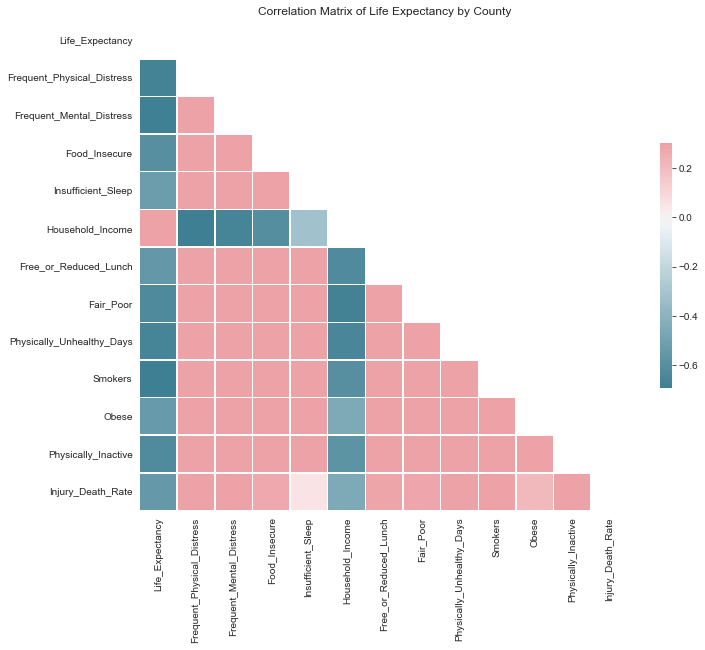

In [27]:
utils.corr_matrix(md)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c233a81d0>,
      dtype=object)

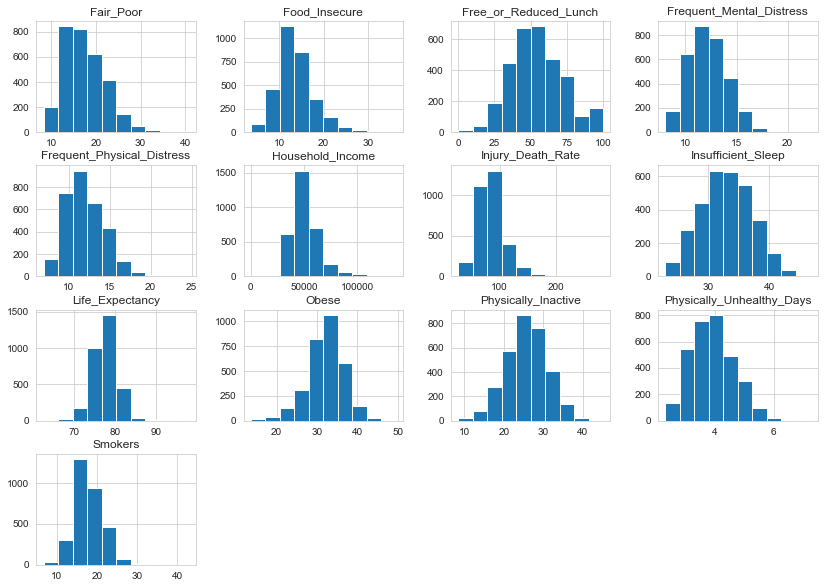

In [28]:
md.hist(figsize=(14,10))

In [29]:
ind_vars = " + ".join(md.drop('Life_Expectancy',axis=1).columns)

formula = "Life_Expectancy ~ " + ind_vars
model = smf.ols(formula=formula,data=md).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     565.0
Date:                Tue, 14 Jan 2020   Prob (F-statistic):               0.00
Time:                        16:52:48   Log-Likelihood:                -6064.9
No. Observations:                3142   AIC:                         1.216e+04
Df Residuals:                    3129   BIC:                         1.223e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     91.6064      0.489    187.180      0.000      90.647      92.566
Frequent_Physical_Distress     0.8665      0.130      6.678      0.000       0.612       1.121
Frequent_Mental_Distress      -0.1476      0.065     -2.278      0.023      -0.275      -0.021
Food_Insecure                 -0.1093      0.011     -9.838      0.000      -0.131      -0.088
Insufficient_Sleep            -0.0731      0.012     -6.006      0.000      -0.097      -0.049
Household_Income            1.535e-05   3.84e-06      4.003      0.000    7.83e-06    2.29e-05
Free_or_Reduced_Lunch         -0.0152      0.002     -6.171      0.000      -0.020      -0.010
Fair_Poor                     -0.0995      0.024     -4.121      0.000      -0.147      -0.052
Physically_Unhealthy_Days     -1.7855      0.290     -6.160      0.000      -2.354      -1.217
Smokers                       -0.1709      0.017    -10.155      0.000      -0.204      -0.138
Obese                         -0.0588      0.010     -6.078      0.000      -0.078      -0.040
Physically_Inactive           -0.0784      0.009     -8.374      0.000      -0.097      -0.060
Injury_Death_Rate             -0.0365      0.001    -25.836      0.000      -0.039      -0.034
==============================================================================
Omnibus:                     1216.831   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15688.300
Skew:                           1.472   Prob(JB):                         0.00
Kurtosis:                      13.544   Cond. No.                     8.79e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.79e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

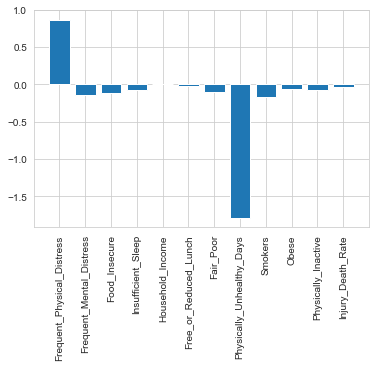

In [30]:
plt.bar(range(len(model.params)-1),model.params[1:])
plt.xticks(np.arange(len(model.params)-1), list(model.params.index)[1:])
plt.xticks(rotation=90)

In [31]:
X =  scaler.fit_transform(md.drop(['Life_Expectancy'],axis=1))
y = md['Life_Expectancy']
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [32]:
poly = PolynomialFeatures(2)
X_fin = poly.fit_transform(X_train)
X_t = poly.fit_transform(X_test)
poly_reg = LinearRegression().fit(X_fin,y_train)
y_pred = poly_reg.predict(X_t)
r2 = r2_score(y_test,y_pred)
print(r2)

0.7399545368958633


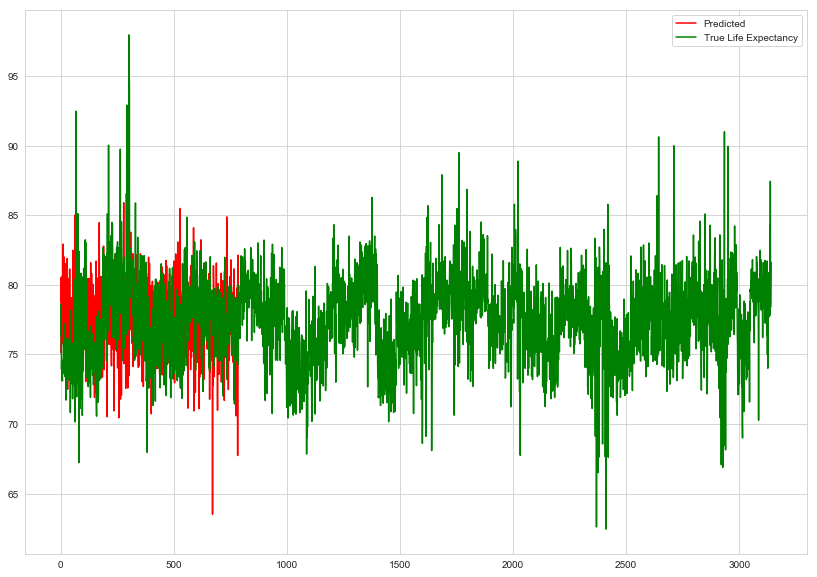

In [33]:
plt.figure(figsize=(14,10))
plt.plot(y_pred, color='r',label="Predicted")
plt.plot(md['Life_Expectancy'], color='g',label="True Life Expectancy")
plt.legend()

In [34]:
model.params.index

Index(['Intercept', 'Frequent_Physical_Distress', 'Frequent_Mental_Distress',
       'Food_Insecure', 'Insufficient_Sleep', 'Household_Income',
       'Free_or_Reduced_Lunch', 'Fair_Poor', 'Physically_Unhealthy_Days',
       'Smokers', 'Obese', 'Physically_Inactive', 'Injury_Death_Rate'],
      dtype='object')